In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import time
import torch
from tqdm import trange, tqdm
from transformers import BertTokenizerFast, AlbertForSequenceClassification, Trainer, TrainingArguments, pipeline, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay
from datasets import Dataset, DatasetDict, load_metric
from google.colab import drive
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [3]:
today = time.strftime("%Y-%m-%d", time.gmtime())
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/tcri_classifier_training/source')
df = pd.read_excel("tcri_training_use.xlsx").dropna(axis=0, how='any').reset_index(drop=True)
df.rename(columns={'說明':'texts'}, inplace=True)
# required dictionary
le_i_mapping = {'IF01': 0, 'IF02': 1, 'IF03': 2, 'IH01': 3, 'IH02': 4, 'IL01': 5, 'IP01': 6, 'IP02': 7,
                'IP03': 8, 'IP04': 9, 'IR01': 10, 'IR02': 11, 'IS01': 12, 'IS02': 13, 'IS03': 14, 'IS04': 15, 'others': 16}
le_i_mapping_inverse = {v: k for k, v in le_i_mapping.items()}

le_a_mapping_inverse = {0: 'AF01', 1: 'AF02', 2: 'AF03', 3: 'AF04', 4: 'AF05', 5: 'AF06',
                        6: 'AF07', 7: 'AF08', 8: 'AF09', 9: 'AI01', 10: 'AI02', 11: 'AI03', 12: 'AI04', 13: 'others'}
le_a_mapping = {v: k for k, v in le_a_mapping_inverse.items()}

le_f_mapping_inverse = {0: 'FS01', 1: 'FS03',
                        2: 'FS04', 3: 'FS05', 4: 'FS06', 5: 'others'}
le_f_mapping = {v: k for k, v in le_f_mapping_inverse.items()}

le_m_mapping_inverse = {0: 'MC01', 1: 'MC02', 2: 'MC03', 3: 'MC04', 4: 'MF01', 5: 'MF03', 6: 'MO01', 7: 'MO02', 8: 'MO03',
                        9: 'MO04', 10: 'MO05', 11: 'MO07', 12: 'MT01', 13: 'MT02', 14: 'MT03', 15: 'MT04', 16: 'MT05', 17: 'MT06', 18: 'others'}
le_m_mapping = {v: k for k, v in le_m_mapping_inverse.items()}

le_r_mapping_inverse = {0: 'RB03', 1: 'RB04', 2: 'RB05', 3: 'RB06', 4: 'RB07', 5: 'RB08', 6: 'RB10', 7: 'RB11',
                        8: 'RB13', 9: 'RD01', 10: 'RD02', 11: 'RD03', 12: 'RD04', 13: 'RD06', 14: 'RD07', 15: 'RD08', 16: 'RD09', 17: 'others'}
le_r_mapping = {v: k for k, v in le_r_mapping_inverse.items()}

le_3_mapping = {'A': 0, 'F': 1, 'M': 2, 'R': 3, 'others': 4}

if not os.path.exists(f'/content/drive/MyDrive/tcri_classifier_training/model/we-the-best-model-{today}'):
  os.mkdir(f'/content/drive/MyDrive/tcri_classifier_training/model/we-the-best-model-{today}')
else:
  pass

last_checkpoint_date = '2023-07-10'

Mounted at /content/drive


# Classifier 1

In [5]:
# data preprocessing
df['labels'] = df['*小分類碼'].apply(lambda x: x[0] if x[0]=='I' else 'others')
train_df, test_df = train_test_split(df, train_size=0.7, random_state=666, stratify=df['labels'])
trainset, testset = Dataset.from_pandas(train_df), Dataset.from_pandas(test_df)
mydata = DatasetDict({'trainset':trainset, 'testset':testset})
tokenizer = BertTokenizerFast.from_pretrained('ckiplab/albert-tiny-chinese')
le_1_mapping = {'I':0, 'others':1}

# tokenization
def tokenization(batch):
  tokenized_batch = tokenizer(batch['texts'], padding='max_length', truncation=True, max_length=512)
  tokenized_batch["labels"] = [le_1_mapping[label] for label in batch["labels"]]
  return tokenized_batch
tokenized_dataset = mydata.map(tokenization, batched = True)
trainset = tokenized_dataset['trainset']
testset = tokenized_dataset['testset']

# training
os.chdir('/content/drive/MyDrive/tcri_classifier_training/model')
def compute_metrics(eval_pred):
    metric1 = load_metric("f1")
    metric2 = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_score = metric1.compute(predictions=predictions, references=labels)["f1"]
    accuracy_score = metric2.compute(predictions=predictions, references=labels)["accuracy"]
    return {"f1": f1_score, "accuracy": accuracy_score}

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.6013 , 2.9674]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

train_args = TrainingArguments(
    output_dir = 'train_step_1',
    overwrite_output_dir = True,
    num_train_epochs = 3,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    warmup_steps = 100,
    weight_decay = 0.01,
    lr_scheduler_type = 'cosine',
    logging_steps = 250,
    save_strategy = 'epoch',
    # save_total_limit = 1,
    evaluation_strategy = 'epoch',
    # greater_is_better = True,
    # metric_for_best_model = 'f1',
    load_best_model_at_end = True,
    seed = 666
)

model_name = f'/content/drive/MyDrive/tcri_classifier_training/model/we-the-best-model-{last_checkpoint_date}/step_1'
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=2)

trainer = Trainer(
    model = model,
    args = train_args,
    train_dataset = trainset,
    eval_dataset = testset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model(f'/content/drive/MyDrive/tcri_classifier_training/model/we-the-best-model-{today}/step_1')

Map:   0%|          | 0/21275 [00:00<?, ? examples/s]

Map:   0%|          | 0/9118 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.101300,0.093692,0.893647,0.967317
2,0.075000,0.084096,0.912680,0.971375
3,0.054000,0.093253,0.916723,0.973020


<ipython-input-5-78f5319b8b09>:21: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("f1")


100%|██████████| 30393/30393 [04:32<00:00, 111.51it/s]


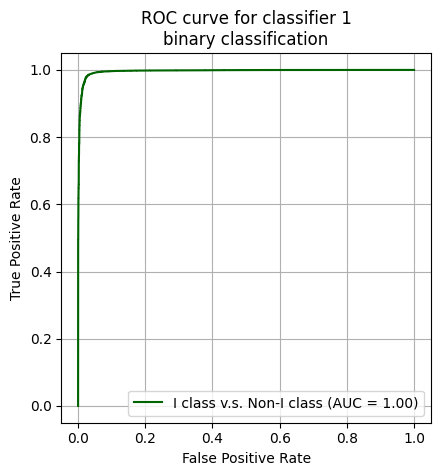

In [43]:
df_2 = df.copy()
device = torch.device('cuda')
model_name = f'/content/drive/MyDrive/tcri_classifier_training/model/we-the-best-model-{today}/step_1'
test_model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
tokenizer = BertTokenizerFast.from_pretrained('ckiplab/albert-tiny-chinese')
sm = torch.nn.Softmax(dim=1)

logit_saver, pred_saver = [], []

for ind in tqdm(df_2.index):
  inputs = tokenizer(df_2.loc[ind, 'texts'], padding='max_length', truncation=True, max_length=512, return_tensors="pt").to(device)
  outputs = test_model(**inputs)
  logits = sm(outputs.logits).cpu().detach().numpy()
  df_2.loc[ind, 'first_prob'] = np.max(logits)
  df_2.loc[ind, 'first_pred'] = np.argmax(logits)

  logit_saver.append(logits)
  pred_saver.append(np.argmax(logits))

df_I = df_2[df_2['first_pred'] == 0].copy()
df_other = df_2[df_2['first_pred'] == 1].copy()

df_ = df.copy()
df_['*小分類碼'] = df_['*小分類碼'].apply(lambda x: 1 if x.startswith('I') else 0)
y_true = df_['*小分類碼'].values
logit_saver_ = np.array(logit_saver)

if not os.path.exists(f"/content/drive/MyDrive/tcri_classifier_training/ROC curve/{today}"):
  os.mkdir(f"/content/drive/MyDrive/tcri_classifier_training/ROC curve/{today}")
else:
  pass

RocCurveDisplay.from_predictions(
    y_true,
    np.squeeze(logit_saver_, 1)[:, 0],
    name= "I class v.s. Non-I class",
    color="darkgreen"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for classifier 1\nbinary classification")
plt.grid()
plt.legend()
plt.savefig(f"/content/drive/MyDrive/tcri_classifier_training/ROC curve/{today}/classifier 1.jpg")
plt.show()